In [13]:
import tensorflow as tf
import numpy as np
import constants
import controller.snake_env as controller
import matplotlib.pyplot as plt

from tqdm import tqdm
import mitdeeplearning as mdl

In [15]:
MAX_EPOCHS = 150
env = controller.SnakeEnv()

n_observations = 2048
n_actions = 4

In [3]:
### Define the Snake agent ###

# Defines a feed-forward neural network
def create_snake_model():
  model = tf.keras.models.Sequential([
      # First Dense layer
      tf.keras.layers.Dense(units=11, activation='relu'),
      tf.keras.layers.Dense(units=4, activation=None)
  ])
  return model

snake_model = create_snake_model()

In [4]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model, 
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation which is fed as input to the model
# Returns:
#   action: choice of agent action
def choose_action(model, observation):
  # add batch dimension to the observation
  observation = np.expand_dims(observation, axis=0)

  '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
  logits = model.predict(observation) # TODO
  
  # pass the log probabilities through a softmax to compute true probabilities
  prob_weights = tf.nn.softmax(logits).numpy()
  
  '''TODO: randomly sample from the prob_weights to pick an action.
  Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0] # TODO


  return action

In [5]:
### Agent Memory ###

class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      '''TODO: update the list of actions with new action'''
      self.actions.append(new_action) # TODO
      '''TODO: update the list of rewards with new reward'''
      self.rewards.append(new_reward) # TODO
        
memory = Memory()

In [6]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # update the total discounted reward
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

In [7]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
  '''TODO: complete the function call to compute the negative log probabilities'''
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions) # TODO
  
  '''TODO: scale the negative log probability by the rewards'''
  loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
  return loss

In [8]:
### Training step (forward and backpropagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propagate through the agent network
      logits = model(observations)

      '''TODO: call the compute_loss function to compute the loss'''
      loss = compute_loss(logits, actions, discounted_rewards) # TODO

  '''TODO: run backpropagation to minimize the loss using the tape.gradient method'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

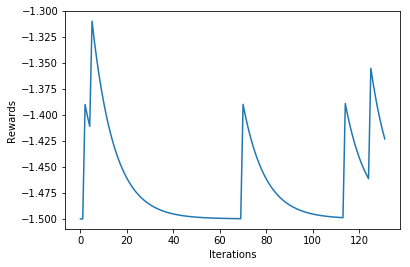

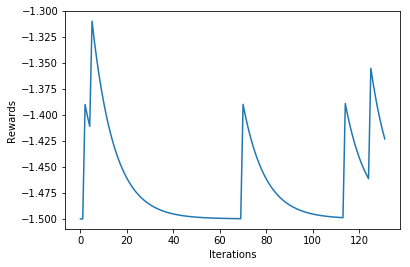

In [16]:
### Cartpole training! ###

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
snake_model = create_snake_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(MAX_EPOCHS):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()
  memory.clear()

  while True:
      # using our observation, choose an action and take it in the environment
      action = choose_action(snake_model, observation)
      next_observation, reward, done, info = env.step(action)
      # add to memory
      memory.add_to_memory(observation, action, reward)
      
      # is the episode over? did you crash or do so well that you're done?
      if done:
          # determine total reward and keep a record of this
          total_reward = sum(memory.rewards)
          smoothed_reward.append(total_reward)
          
          # initiate training - remember we don't know anything about how the 
          #   agent is doing until it has crashed!
          train_step(snake_model, optimizer, 
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          # reset the memory
          memory.clear()
          break
      # update our observatons
      observation = next_observation